In [1]:
import cv2
import numpy as np
from utils import show_images

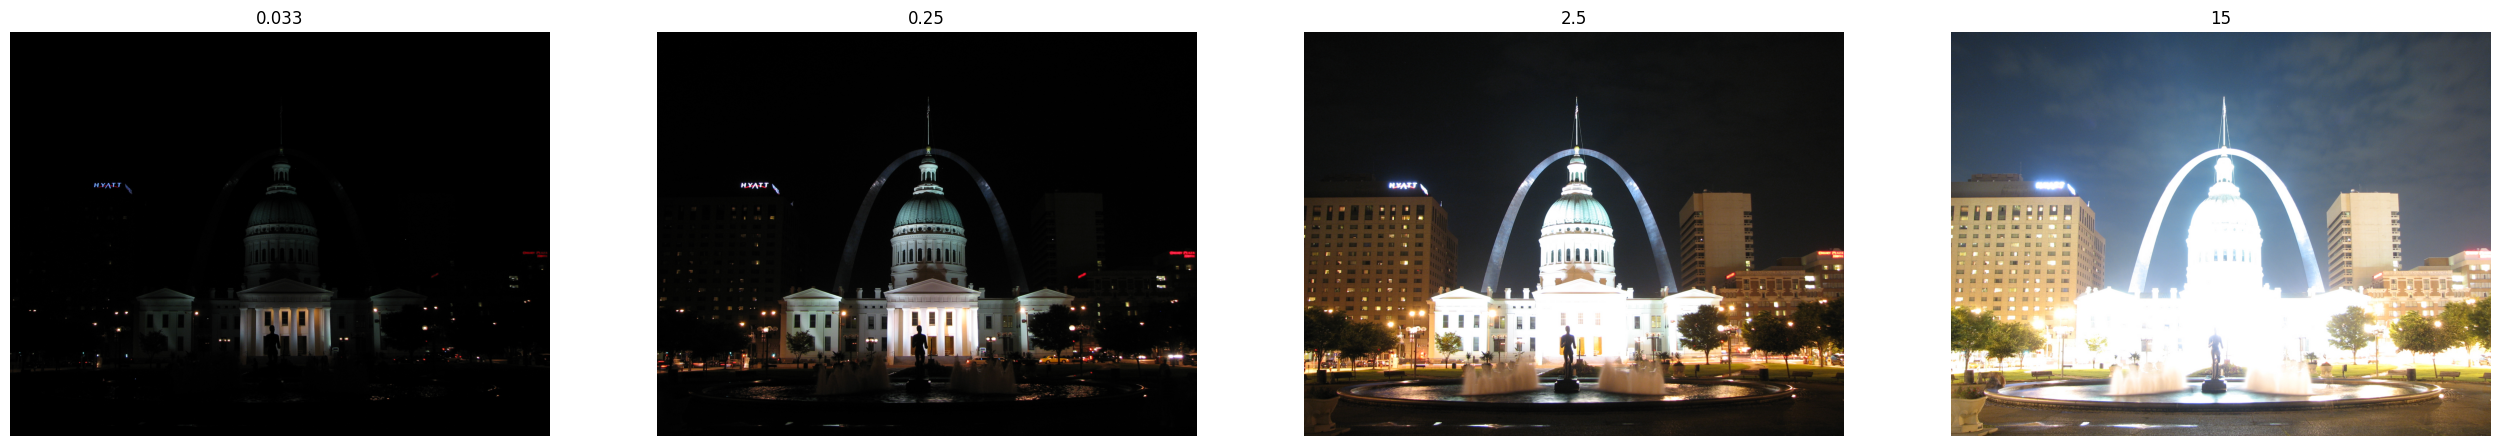

In [2]:
exp_times = [0.033, 0.25, 2.5, 15]

images = []
for now_exp in exp_times:
    images.append(cv2.imread(f'./image/hdr_imgs/img_{now_exp}.jpg', -1))

show_images([(now_exp, now_img) for now_exp, now_img in zip(exp_times, images)])

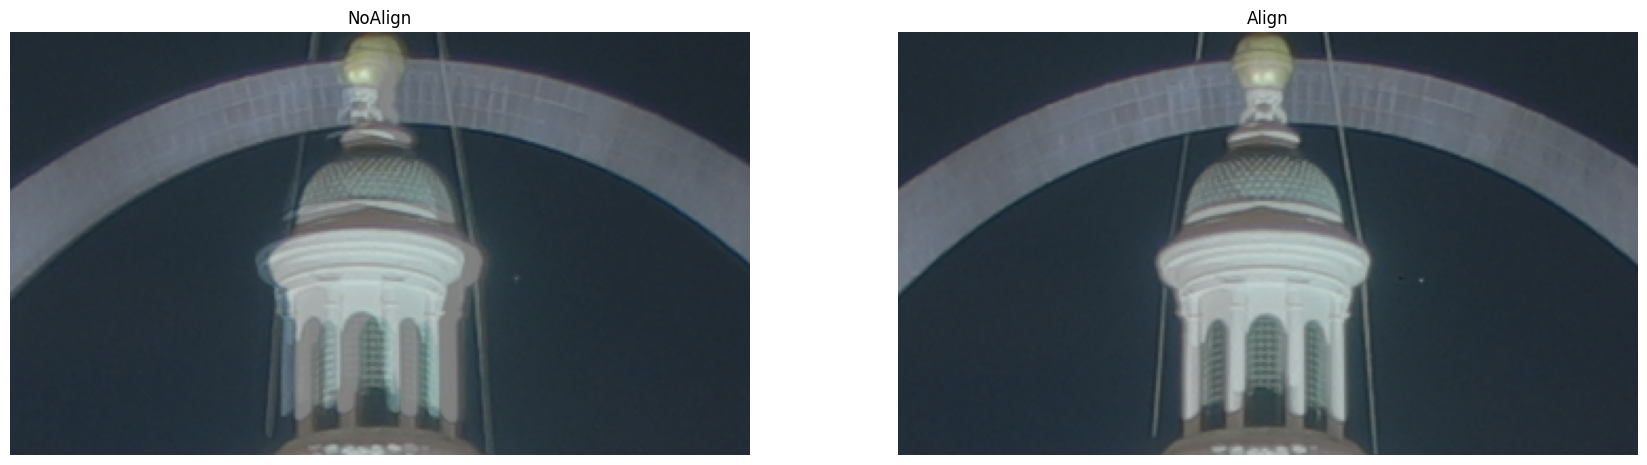

In [3]:
# 对齐和不对齐显示
result = []

mean_img = np.mean(images, axis=0).astype(np.uint8)
result.append(['NoAlign', np.copy(mean_img)[600:800, 1250:1600]])

alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)
mean_img = np.mean(images, axis=0).astype(np.uint8)
result.append(['Align', np.copy(mean_img)[600:800, 1250:1600]])

show_images(result)

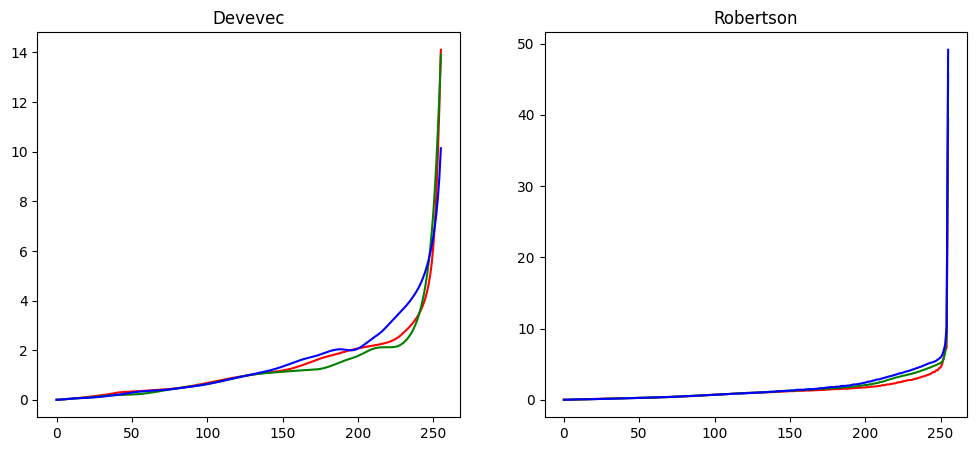

In [4]:
import matplotlib.pyplot as plt

# 获取相机的响应曲线 Camera Response Function (CRF)
result = []
    
exp_times = np.array(exp_times, dtype=np.float32)

# 返回值: (256, 1, 3)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, exp_times)

calibrateRobertson = cv2.createCalibrateRobertson()
responseRobertson = calibrateRobertson.process(images, exp_times)

# 画图
responses = [responseDebevec, responseRobertson]
titles = ['Devevec', 'Robertson']
fig, axes = plt.subplots(1, len(responses), figsize=(12, 5))
for i, response in enumerate(responses):
    axes[i].set_title(titles[i])
    axes[i].plot(response[..., 0], color='r')
    axes[i].plot(response[..., 1], color='g')
    axes[i].plot(response[..., 2], color='b')


In [5]:
# Merge images into an HDR linear image

# 只展示 Debevec；还有其他两个方法 Robertson, Mertens
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, exp_times, responseDebevec)

# # Save HDR image.
# cv2.imwrite("hdrDebevec.hdr", hdrDebevec)

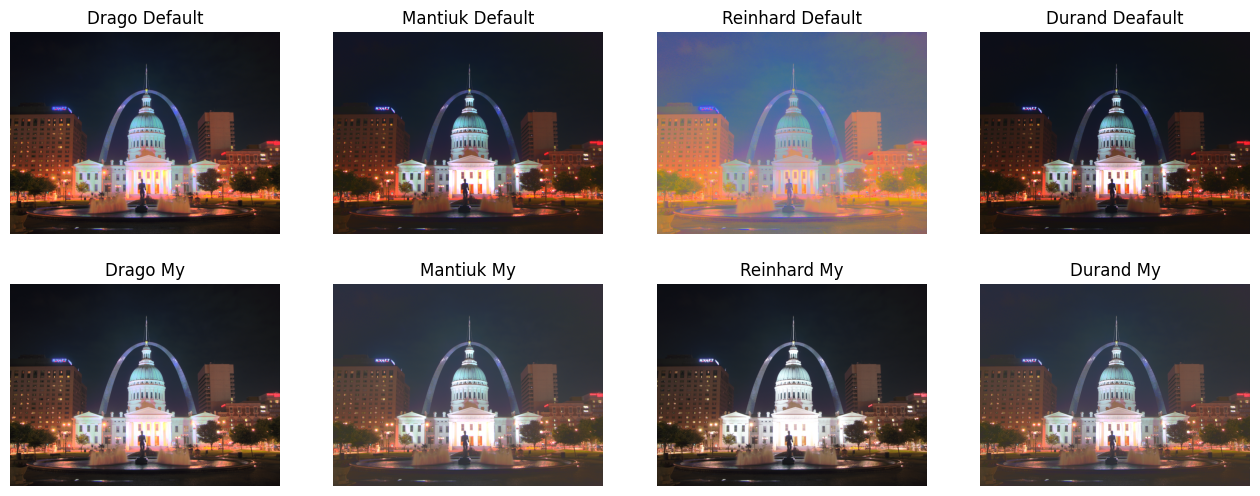

In [29]:
# Tonemap methods
def to_ldr(now_method, hdr_img):
    ldr_img = now_method.process(hdr_img)

    # 去除过于离散的点后再进行归一化
    meanv, stdv = np.mean(ldr_img), np.std(ldr_img)
    minv = max(meanv-3*stdv, ldr_img.min())
    maxv = min(meanv+3*stdv, ldr_img.max())
    ldr_img = (ldr_img - minv) / (maxv - minv)

    ldr_img = (ldr_img * 255).clip(0, 255).astype('uint8')

    return ldr_img

tonemapDrago = cv2.createTonemapDrago()
ldrDrago0 = to_ldr(tonemapDrago, hdrDebevec)

tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago1 = to_ldr(tonemapDrago, hdrDebevec)

tonemapMantiuk = cv2.createTonemapMantiuk()
ldrMantiuk0 = to_ldr(tonemapMantiuk, hdrDebevec)

tonemapMantiuk = cv2.createTonemapMantiuk(2.2,0.85, 1.2)
ldrMantiuk1 = to_ldr(tonemapMantiuk, hdrDebevec)

tonemapReinhard = cv2.createTonemapReinhard()
ldrReinhard0 = to_ldr(tonemapReinhard, hdrDebevec)

tonemapReinhard = cv2.createTonemapReinhard(1.5, 0,0,0)
ldrReinhard1 = to_ldr(tonemapReinhard, hdrDebevec)

# This algorithm decomposes image into two layers: base layer and detail layer using bilateral filter.
# Compresses contrast of the base layer thus preserving all the details.
# You need to set the OPENCV_ENABLE_NONFREE option in cmake to use those. Use them at your own risk.
tonemapDurand = cv2.xphoto.createTonemapDurand()
ldrDurand0 = to_ldr(tonemapDurand, hdrDebevec)

tonemapDurand = cv2.xphoto.createTonemapDurand(contrast=2.5, saturation=0.6)
ldrDurand1 = to_ldr(tonemapDurand, hdrDebevec)

show_images([
    ('Drago Default', ldrDrago0), 
    ('Mantiuk Default', ldrMantiuk0), 
    ('Reinhard Default', ldrReinhard0), 
    ('Durand Deafault', ldrDurand0),

    ('Drago My', ldrDrago1), 
    ('Mantiuk My', ldrMantiuk1), 
    ('Reinhard My', ldrReinhard1), 
    ('Durand My', ldrDurand1), 
], colnum=4)